# Deep Learning and Inverse Problems - Summer 2024
## Problem Set 9 -- Solution

**Issued**: Tuesday, June 25, 2024, 1:00 pm

**Due**: Tuesday, July 2, 2024, 1:00 pm

# Computational Tomography with Un-trained Neural Networks

In this exercise, the task is to reconstruct an image in the context of computational tomography. The original images is given as $x$ below, and is loaded from the the file origina.npy, which must be in the same folder as this notebook.

Below, you are given the measurement operator $A$ and a measurement obtained as
$$
y = A x.
$$
The task is to reconstruct the image $x$ from $y$ with an un-trained neural network. You are welcome to use code from any repository of your choice, for example:
- Deep image prior: [https://github.com/DmitryUlyanov/deep-image-prior](https://github.com/DmitryUlyanov/deep-image-prior)
- Deep decoder: [https://github.com/reinhardh/supplement_deep_decoder](https://github.com/reinhardh/supplement_deep_decoder)
- Compressive sensing with the deep decoder [https://github.com/MLI-lab/cs_deep_decoder](https://github.com/MLI-lab/cs_deep_decoder)
To make this work, you might have to tune the network and optimization appropriately.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as F
import torch.nn as nn
from torch.autograd import Variable
import torch.optim
import copy


In [2]:
#Load ground truth

x_path='./original.npy'  #path to ground truth
x=np.load(x_path)        #load ground truth

x=torch.FloatTensor(x)

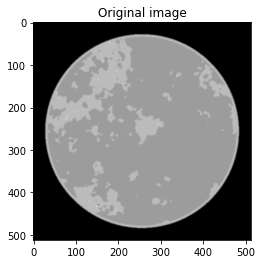

In [3]:
#Plot original image

plt.imshow(x)
plt.gray()
plt.title('Original image')
plt.show()
x=x.unsqueeze(0).unsqueeze(0)

In the following we define the forward model $A$, which represents a parallel beam projection (also known as a discrete radon transform) with a 4x acceleration factor.

In [4]:
#Forward Model A

def A(image):
    n=image.shape[2]
    m=n//4 # 4 times acceleration
    pbp = torch.zeros(m,n)
    image=image.squeeze(0)
    
    for i in range(m):
        proj = F.rotate(image, -i*180/m).squeeze(0)
        pbp[i,:] = torch.sum(proj,0)
        
    return pbp.unsqueeze(0).unsqueeze(0)

The measurement, $y$, is created by: $y=A(x)$

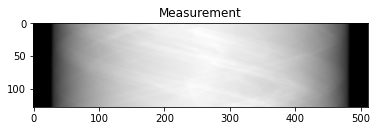

In [5]:
#create and plot measurement
y=A(x)

plt.imshow(y.squeeze(0).squeeze(0))
plt.title('Measurement')
plt.show()

In [6]:
device='cuda'
x=x.to(device)
y=y.to(device)

In [7]:
#Network Architecture of convolutional decoder

def add_module(self, module):
    self.add_module(str(len(self) + 1), module)
torch.nn.Module.add = add_module

class conv_model(nn.Module):
    def __init__(self, num_layers, num_channels, num_output_channels, out_size, in_size):
        super(conv_model, self).__init__()

        ### parameter setup
        kernel_size = 3
        strides = [1]*(num_layers-1)
        
        ### compute up-sampling factor from one layer to another
        scale_x,scale_y = (out_size[0]/in_size[0])**(1./(num_layers-1)), (out_size[1]/in_size[1])**(1./(num_layers-1))
        hidden_size = [(int(np.ceil(scale_x**n * in_size[0])),
                        int(np.ceil(scale_y**n * in_size[1]))) for n in range(1, (num_layers-1))] + [out_size]
        
        ### hidden layers
        self.net = nn.Sequential()
        for i in range(num_layers-1):
            
            self.net.add(nn.Upsample(size=hidden_size[i], mode='nearest'))
            conv = nn.Conv2d(num_channels, num_channels, kernel_size, strides[i], padding=(kernel_size-1)//2, bias=True)
            self.net.add(conv)
            self.net.add(nn.ReLU())
            self.net.add(nn.BatchNorm2d( num_channels, affine=True))
        ### final layer
        self.net.add(nn.Conv2d(num_channels, num_channels, kernel_size, strides[i], padding=(kernel_size-1)//2, bias=True) )
        self.net.add(nn.ReLU())
        self.net.add(nn.BatchNorm2d( num_channels, affine=True))
        self.net.add(nn.Conv2d(num_channels, num_output_channels, 1, 1, padding=0, bias=True))
        
    def forward(self, x, scale_out=1):
        return self.net(x)*scale_out

In [8]:
### Hyper-parameters
in_size = [10,5]        # network input size
kernel_size = 3        # size of convolutional filters
num_layers = 20         # number of layers
num_channels = 64   # number of channels per layer (except the final layer)
output_depth = 1 # number of output channels
out_size = (512,512)  # network output size

### create a randomly-initialized network ###
net = conv_model(num_layers,num_channels, output_depth,out_size,in_size).to(device)

In [9]:
#Define decoder input
shape = [1,num_channels, in_size[0], in_size[1]]
ni = Variable(torch.zeros(shape))
ni.data.uniform_()
ni = ni.to(device)
    

In [10]:
#Use inverse radon transform to implement data consistency

from skimage.transform import iradon

def AT(y):
    y=y.squeeze(0).squeeze(0).T.cpu().numpy()
    theta = np.linspace(0., 180., 128, endpoint=False)
    back_proj=iradon(y,theta,filter_name='ramp')
    return torch.FloatTensor(back_proj).unsqueeze(0).unsqueeze(0).to(device)

x_backproj=AT(y)
DC= 0.01* AT(A(x_backproj).to(device) - y)

In [11]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=500):
    """Decay learning rate by a factor of 0.7 every lr_decay_epoch epochs."""
    lr = init_lr * (0.7**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

def fit(net,              # decoder network
        img_noisy,        # measurement
        gt,               #ground truth for reporting loss
        num_channels,     # number of channles in each layer (it's a list containing #channels for all layers)
        apply_f,          # forward model
        num_iter ,        # number of gradient iterations
        LR ,              # stepsize
        lr_decay_epoch = 0, #when to decay LR
       ):
    
    p = [i for i in net.parameters() ]
    
    ### optimizer
    print("optimize with adam", LR)
    optimizer = torch.optim.Adam(p, lr=LR)

    ### loss function
    mse = torch.nn.MSELoss() 
    
    ### we return the best network across the iterations w.r.t fitting loss
    best_net = copy.deepcopy(net)
    best_mse = 1000000.0
        
    ### main optimization loop
    for i in range(num_iter):
       
        if lr_decay_epoch != 0:
            optimizer = exp_lr_scheduler(optimizer, i, init_lr=LR, lr_decay_epoch=lr_decay_epoch)        
        
        def closure():
            optimizer.zero_grad()
            out = net(ni)
            
            # training loss 
            recovery=x_backproj - DC + out
            loss = mse( apply_f(recovery).to(device) , img_noisy )
            loss.backward()
            
            loss2=mse(recovery,gt)
            
            ### display the fitting loss every 10 iterations
            if i % 10 == 0:
                print ('Iteration %05d    Train loss %f    Loss wrt Original %f' % (i, loss.data, loss2.data), '\r', end='')
            return loss   
        
        ### call the optimization step
        loss = optimizer.step(closure)
            
        # if training loss improves by at least one percent, we found a new best net
        if best_mse > 1.005*loss.data:
            best_mse = loss.data
            best_net = copy.deepcopy(net)
                 

    final_image=x_backproj - DC + best_net(ni)
    
    return final_image

In [12]:
recon  = fit(copy.deepcopy(net),
                          y,
                          x,
                          [num_channels]*(num_layers-1),
                          apply_f =A,
                          num_iter=5000,
                          LR=0.01,
                          lr_decay_epoch=3000  
                          )



optimize with adam 0.01
LR is set to 0.01
LR is set to 0.00699999999999999910627    Loss wrt Original 0.000094   


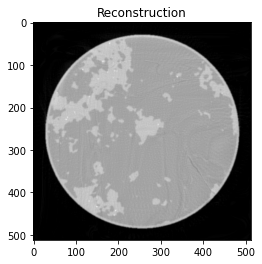

In [28]:
plt.imshow(recon.cpu().detach().squeeze(0).squeeze(0).numpy())
plt.title('Reconstruction')
plt.show()

In [26]:
loss=nn.MSELoss()
print('The MSE between the reconstructed and original image is: ',loss(recon,x).item() )

The MSE between the reconstructed and original image is:  7.713476952631027e-05
